In [1]:
import tellurium as te
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.optimize
from xlink_kme_sbml.library import sbml_sim_helper

In [2]:
str_time = 'time'
str_var = 'variable'
str_value = 'value'
str_species = 'species'
str_pos = 'pos'
str_data_type = 'data_type'
str_val_type = 'value_type'
str_fit_type = "fit_type"
str_fit_y_errs = "fit_y_errors"
str_fit_intercept = "fit_intercept"

str_is_linker = "is_linker"
str_conc_linker = "linker_conc"

str_val_base = 'base'
str_val_base_log = 'base_log'
str_val_diff = 'diff'
str_val_diff_log = 'diff_log'

str_rep = 'replicate'

str_type_exp = 'experiment'
str_type_rep_mean = 'replicate mean'
str_type_truth = 'truth'

str_species_mono_base = "Mono"
str_species_mono_hydro = "MonoHydro"
str_species_mono_sum = "MonoSum"
str_species_crosslinker = "Crosslinker"
str_species_monolinker = "Monolinker"
str_species_lys = "LYS"

str_fit_rel_error = "fit_rel_error"
str_mean_rel_error = "mean_rel_error"
str_std_rel_error = "std_rel_error"

In [3]:
def calc_mono_sum(df):
    df = df.copy(deep=True)
    cols_mono_hydro = [col for col in df.columns if f"{str_species_mono_hydro}_" in col]
    pos_list = [pos.split("_")[1].replace("]", "") for pos in cols_mono_hydro]    
    if f"[{str_species_monolinker}]" in df.columns:
        for pos in pos_list:
            df[f"{str_species_mono_sum}_{pos}"] = df[f"[{str_species_mono_hydro}_{pos}]"]    
        return df
    cols_mono = [col for col in df.columns if f"{str_species_mono_base}_" in col]
    for pos in pos_list:
        df[f"{str_species_mono_sum}_{pos}"] = df[f"[{str_species_mono_base}_{pos}]"] + df[f"[{str_species_mono_hydro}_{pos}]"]
    return df

In [4]:
def calc_mono_sum_melt(df_melt):
    df_n = df_melt.copy(deep=True)
    df_n = df_n[(df_n[str_species] == str_species_mono_hydro) | (df_n[str_species] == str_species_mono_base)]
    if (str_species_mono_hydro in df_n[str_species].unique()) and (str_species_mono_base in df_n[str_species].unique()):
        min_count = 2
    else:
        min_count = 1
    df_n = df_n.groupby([str_val_type, str_data_type, str_rep, str_pos, str_time]).sum(min_count=min_count).reset_index()
    df_n[str_species] = str_species_mono_sum
    #df_n[str_var] = df_n[str_species] + "_" + df_n[str_pos].map(str)
    df_n[str_var] = df_n.agg(lambda x: f"{x[str_species]}_{x[str_pos]}", axis=1)
    return pd.concat([df_melt, df_n]).reset_index(drop=True)
    

In [5]:
def data_scrambler(data, sparseness=0.1, gaussian_noise=0.3):
    data_noise = []
    mean = np.mean(data)
    for val in data:
        val_noise = mean * np.random.normal(scale=gaussian_noise)
        new_val = val + val_noise
        if new_val < 0:
            new_val = 0
        if np.random.uniform() <= sparseness:
            data_noise.append(np.nan)
        else:
            data_noise.append(new_val)
    return data_noise

In [6]:
def linear_func(x, m, b):
    return m * x + b
def linear_func_no_intercept(x, m):
    return m * x

In [7]:
def do_linear_fit(df_melt, variable, value_type, fit_to, time_limit=10, fit_intercept=True, fit_y_errors=True):
    #fit_to: replicate number for single rep fit OR "truth" for fit to true values OR "mean" for fit to replicate mean
    df_melt = df_melt.copy(deep=True)
    df_list = []
    variables = df_melt[str_var].unique()
    variables_filtered = [var for var in variables if variable in var]
    prefilter = (df_melt[str_time] <= time_limit) & (df_melt[str_val_type] == value_type) & (df_melt[str_var].isin(variables_filtered))
    if fit_to == 'truth':
        prefilter &= (df_melt[str_data_type] == str_type_truth)
        fit_type = fit_to
        fit_y_errors = False
    elif type(fit_to) == int:
        prefilter &= (df_melt[str_data_type] == str_type_exp)
        prefilter &= (df_melt[str_rep] == fit_to)
        fit_type = f"{str_rep}_{fit_to}"
        fit_y_errors = False
    elif fit_to == 'mean':
        prefilter &= (df_melt[str_data_type] == str_type_exp)
        fit_type = fit_to
    else:
        print("WARNING: Unkown fit option")
        exit(1)
    df_melt = df_melt[prefilter].reset_index(drop=True)
    if fit_to == 'mean':
        df_melt = df_melt.groupby([str_var, str_time])[[str_value]].agg(['mean', 'std']).reset_index(col_level=1)
        df_melt.columns = df_melt.columns.droplevel(0)
        df_melt = df_melt.rename(columns={'mean': str_value})
        df_melt = create_type_pos_columns(df_melt)
        
    for var in variables_filtered:
        df_filtered = df_melt[df_melt[str_var] == var]
        x = df_filtered[str_time]
        y = df_filtered[str_value]
        valid = (np.isfinite(x) & np.isfinite(y))
        if valid.sum() == 0:
            continue
        if (fit_to == 'mean') and fit_y_errors:
            y_err = df_filtered['std']
            y_err = y_err.fillna(1)
            y_err = y_err.replace(0, 1)
            y_err = y_err[valid]
        else:
            y_err = None
        #m, b = np.polyfit(x, y, 1)
        try:
            if fit_intercept:
                popt, pcov = scipy.optimize.curve_fit(linear_func, x[valid], y[valid], sigma=y_err)
                m, b = popt
            else:
                popt, pcov = scipy.optimize.curve_fit(linear_func_no_intercept, x[valid], y[valid], sigma=y_err)
                m = popt[0]
                b = 0
        except ValueError:
            print(f"Invalid values in fit: {x[valid]}, {y[valid]}")
            continue
        perr = np.sqrt(np.diag(pcov))
        m_err = perr[0]
        if fit_intercept:
            b_err = perr[1]
        else:
            b_err = 0
        df_list.append(pd.DataFrame.from_dict({str_var: [var], "m": [m], "b": [b], "m_err": [m_err], "b_err": [b_err], str_pos: df_filtered[str_pos].unique()}))
        df_concat = pd.concat(df_list).reset_index(drop=True)
        df_concat[str_fit_type] = fit_type
        df_concat[str_fit_y_errs] = fit_y_errors
        df_concat[str_fit_intercept] = fit_intercept
    return df_concat

In [8]:
def create_diff_cols(df_melt, val_col='value'):
    def __create_new_vals(df, val_col, val_type, operation):
        df = df.copy(deep=True)
        if operation == "log":
            df[val_col] = np.log(df[val_col])
        elif operation == 'diff':
            df_lys_t0 = df[(df[str_species] == str_species_lys) & (df[str_time].round(1) == 0)] 
            df_lys_t0 = df_lys_t0.drop(columns=[str_var, str_time, str_species])
            df_lys_t0 = df_lys_t0.rename(columns={str_value: "val_t0"})
            df = pd.merge(df, df_lys_t0, how='outer')
            df[val_col] = df["val_t0"] - df[str_value]
            df = df.drop(columns=["val_t0"])
        else:
            print("ERROR: incorrect operation")
            exit(1)
        df[str_val_type] = val_type
        return df
        
    df_list = []
    
    df_list.append(df_melt)
    df_list.append(__create_new_vals(df_melt, val_col, str_val_base_log, "log"))
    df_diff = __create_new_vals(df_melt, val_col, str_val_diff, "diff")
    df_list.append(df_diff)
    df_list.append(__create_new_vals(df_diff, val_col, str_val_diff_log, "log"))
    
    return pd.concat(df_list).reset_index(drop=True)
    #df_melt[f'{col}_diff'] = 1-df_melt[col]
    #df_melt[f'{col}_diff_log'] = np.log(df_melt[f'{col}_diff'])
    #df_melt[f'{col}_log'] = np.log(df_melt[col])

In [9]:
def create_type_pos_columns(df_melt):
    df_melt = df_melt.copy(deep=True)
    df_melt[[str_species, str_pos]] = df_melt[str_var].str.split("_", expand=True)
    df_melt[str_pos] = df_melt[str_pos].fillna(1)
    df_melt[str_pos] = df_melt[str_pos].astype(int)
    df_melt[str_pos] = pd.Categorical(df_melt[str_pos])
    return df_melt

In [10]:
def create_melt_df(df):
    df_melt = pd.melt(df, id_vars=[str_time])
    df_melt[str_var] = df_melt[str_var].str.replace("\[|\]", "", regex=True)
    df_melt = create_type_pos_columns(df_melt)
    df_melt.loc[df_melt[str_value] < 1e-5, str_value] = 1e-5
    df_melt[str_data_type] = str_type_truth
    df_melt[str_val_type] = str_val_base
    df_melt[str_rep] = 1
    df_melt[str_pos] = pd.Categorical(df_melt[str_pos])
    df_melt[str_rep] = pd.Categorical(df_melt[str_rep])
    mask_linker_species = df_melt[str_species].str.contains(f"{str_species_crosslinker}|{str_species_monolinker}")
    df_melt[str_is_linker] = mask_linker_species
   # df_melt = create_diff_cols(df_melt, val_col=str_value)
    return df_melt

In [11]:
def add_replicates(df_melt, no_replicates, noise_params):
    df_list = []
    df_list.append(df_melt)
    for rep_no in range(1, no_replicates + 1):
        df = df_melt.copy(deep=True)
        df[str_value] = df.groupby([str_is_linker])[str_value].transform(data_scrambler, **noise_params)
        df[str_data_type] = str_type_exp
        df[str_rep] = rep_no
        df_list.append(df)
    
    return pd.concat(df_list).reset_index(drop=True)
        #create_diff_cols(df_melt, col='value_noise')
    

In [12]:
def get_keff_df(custom_vars_dict):
    keff_true_dict = {}
    for kl in custom_vars_dict.keys():
        if 'klys' in kl:
            klys = custom_vars_dict[kl]
            kon = custom_vars_dict['kon']
            koff = custom_vars_dict['koff']
            keff = (kon*klys)/(koff+klys)
            keff_true_dict[kl] = keff
    pos_list = [int(key.split("_")[1]) for key in keff_true_dict]
    #dict(zip(df_c1['variable'], df_c1['value']))
    return pd.DataFrame.from_dict({"variable": list(keff_true_dict.keys()), "k_2nd_true": list(keff_true_dict.values()), "pos": pos_list})

In [13]:
def get_keff_exp_truth_merge(df_keff, df_lin_fit):
    df_lin_fit = df_lin_fit.copy(deep=True)
    df_lin_fit['k_1st_pseudo_fit'] = -df_lin_fit['m']
    if str_species_crosslinker in custom_vars:
        linker = str_species_crosslinker
    elif str_species_monolinker in custom_vars:
        linker = str_species_monolinker
    df_lin_fit['k_2nd_fit'] = df_lin_fit['k_1st_pseudo_fit']/custom_vars[linker]
    df_fit_merge = pd.merge(df_lin_fit, df_keff.drop(columns=str_var), on='pos')
    df_fit_merge["fit_rel_error"] = abs(df_fit_merge['k_2nd_fit']-df_fit_merge['k_2nd_true'])/df_fit_merge['k_2nd_true']
    return df_fit_merge

In [14]:
def set_known_concentration_limits(df_melt, initial_lysine_conc=1):
    df_melt = df_melt.copy(deep=True)
    df_melt.loc[(df_melt[str_time].round(1) == 0.) & ((df_melt[str_species] == str_species_mono_base) | (df_melt[str_species] == str_species_mono_hydro)), str_value] = 0
    df_melt.loc[(df_melt[str_time].round(1) == 0.) & (df_melt[str_species] == str_species_lys), str_value] = initial_lysine_conc
    return df_melt

In [15]:
def get_kin_constants(rr):
    vars_klys = sbml_sim_helper.get_rr_const_dict(rr, 'klys')
    var_kon = sbml_sim_helper.get_rr_const_dict(rr, 'kon')
    var_koff = sbml_sim_helper.get_rr_const_dict(rr, 'koff')
    var_kh = sbml_sim_helper.get_rr_const_dict(rr, 'kh')
    return {**vars_klys, **var_kon, **var_koff, **var_kh}

In [16]:
sim_time = 10
no_of_points = 11

In [17]:
#sbml_sim_helper.get_rr_const_dict(rr, "Crosslinker")

In [18]:
rr = te.loadSBMLModel("/home/kai/Nextcloud-unikn/Coding/xlink_kme_sbml/output/model_example_mono_only_simple_5lys.xml")

In [19]:
if str_species_crosslinker in sbml_sim_helper.get_rr_const_dict(rr, ''):
    print("XL experiment")
    linker = str_species_crosslinker
else:
    print("Mono experiment")
    linker = str_species_monolinker
custom_vars = {'kh': 5e-2, 'kon': 1e-3, 'koff': 1e-1, "klys_1": 0.3, "klys_2": 0.1, "klys_3": 0.075, "klys_4": 0.03, "klys_5": 0.01, linker : 250} #0.16768329

Mono experiment


In [20]:
rr.resetToOrigin()
for k,v in custom_vars.items():
    setattr(rr, k, v)
results = rr.simulate(0, sim_time, points=no_of_points)
df_res_t = pd.DataFrame(results, columns=results.colnames)
#df_res_t = calc_mono_sum(df_res_t)

In [21]:
#sbml_sim_helper.get_rr_const_dict(rr, 'klys')

<AxesSubplot:>

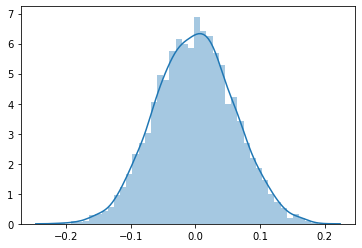

In [22]:
sns.distplot(np.random.normal(scale=0.06, size=5000), kde=True)

In [23]:
df_melt = create_melt_df(df_res_t)

In [24]:
df_melt = add_replicates(df_melt, no_replicates=3, noise_params={"sparseness": 0.1, "gaussian_noise": 0.005})

In [25]:
df_melt = set_known_concentration_limits(df_melt, initial_lysine_conc=1)

In [26]:
df_melt = calc_mono_sum_melt(df_melt)

In [27]:
df_melt = create_diff_cols(df_melt, val_col=str_value)

/opt/miniconda3/envs/te/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning:

divide by zero encountered in log

/opt/miniconda3/envs/te/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning:

divide by zero encountered in log



In [28]:
#df_melt[(df_melt[str_species] == str_species_mono_hydro) | (df_melt[str_species] == str_species_mono_base)].groupby([str_val_type, str_data_type, str_rep, str_pos, str_time]).sum().reset_index()

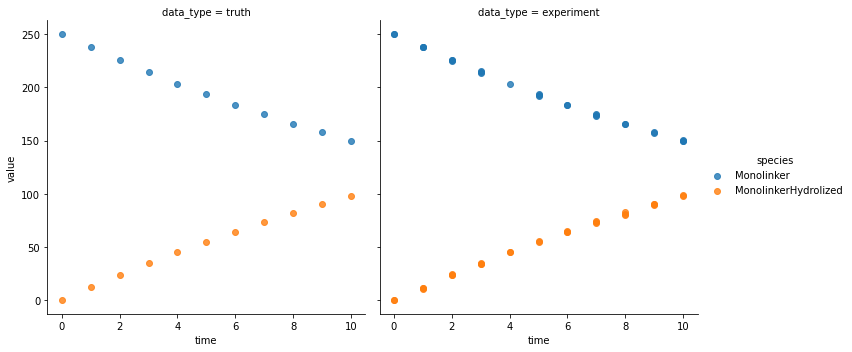

In [29]:
sns.lmplot(data=df_melt[(df_melt[str_species].str.contains(f"{str_species_crosslinker}|{str_species_monolinker}", regex=True)) &
                        (df_melt[str_val_type] == str_val_base)], 
           x=str_time, y=str_value, hue=str_species, fit_reg=False, col=str_data_type)

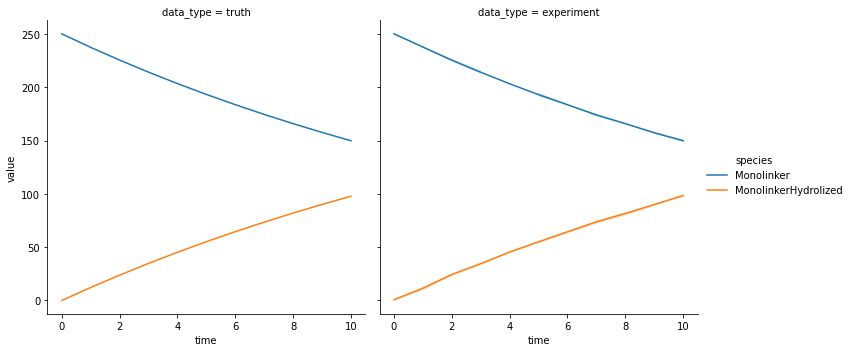

In [30]:
sns.relplot(data=df_melt[(df_melt[str_species].str.contains(f"{str_species_crosslinker}|{str_species_monolinker}", regex=True)) 
                         & (df_melt[str_val_type] == str_val_base)],  
            x=str_time, y=str_value, kind='line', hue=str_species, col=str_data_type)

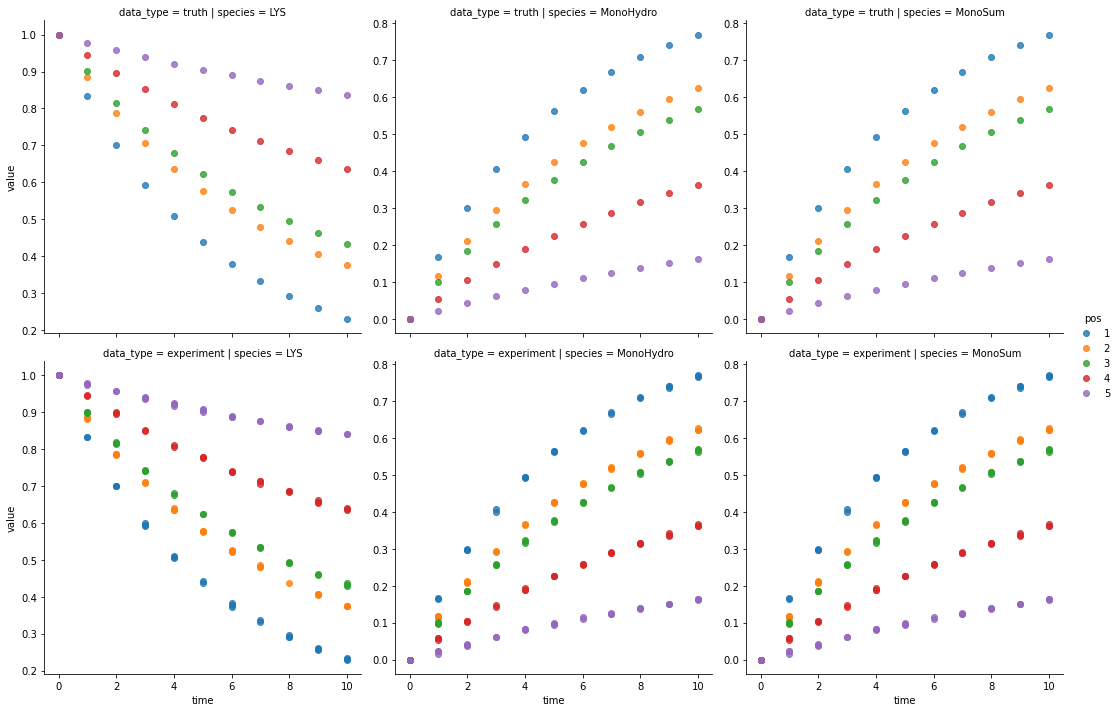

In [31]:
fg = sns.lmplot(data=df_melt[(~df_melt[str_species].str.contains(f"{str_species_crosslinker}|{str_species_monolinker}", regex=True)) &
                             (df_melt[str_val_type] == str_val_base)], 
                x=str_time, y=str_value, col=str_species, hue=str_pos, fit_reg=False, sharey=False, row=str_data_type)

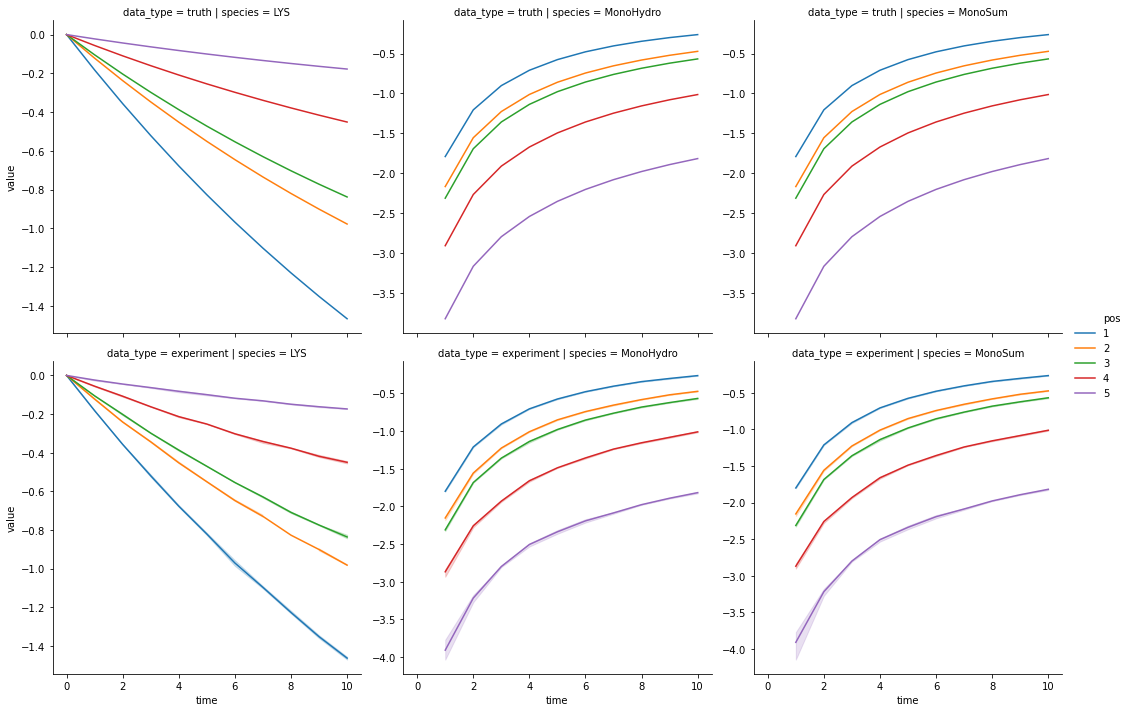

In [32]:
fg = sns.relplot(data=df_melt[(~df_melt[str_species].str.contains(f"{str_species_crosslinker}|{str_species_monolinker}", regex=True)) &
                              (df_melt[str_val_type] == str_val_base_log)],
                 kind='line' ,x=str_time, y=str_value, col=str_species, hue=str_pos, facet_kws={'sharey': False}, row=str_data_type)

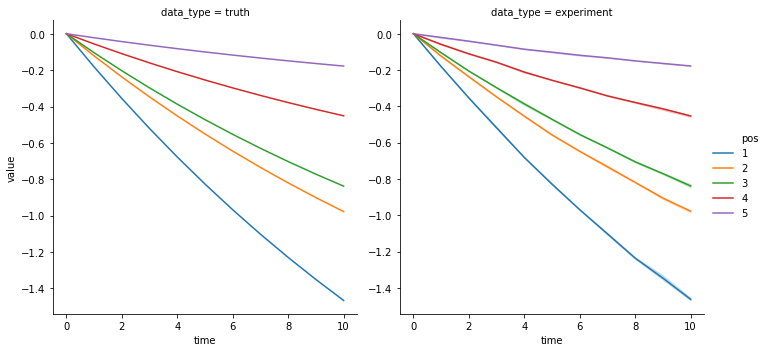

In [33]:
fg = sns.relplot(data=df_melt[(df_melt[str_species] == str_species_mono_sum) &
                              (df_melt[str_val_type] == str_val_diff_log)], 
                 kind='line' ,x=str_time, y=str_value, hue=str_pos, facet_kws={'sharey': False}, col=str_data_type)

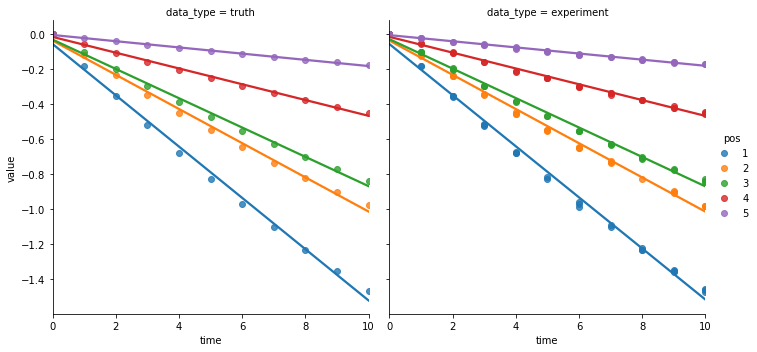

In [34]:
fg = sns.lmplot(data=df_melt[(df_melt[str_species].str.contains(str_species_lys)) &
                             (df_melt[str_time] <= 10) &
                             (df_melt[str_val_type] == str_val_base_log)],
                x=str_time, y=str_value, hue=str_pos, fit_reg=True, col=str_data_type, ci=None)

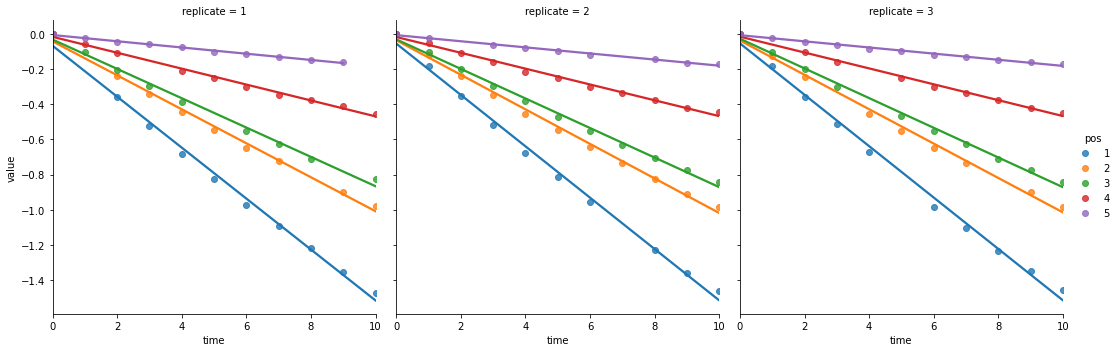

In [35]:
fg = sns.lmplot(data=df_melt[(df_melt[str_species].str.contains(str_species_lys)) &
                             (df_melt[str_time] <= 10) & (df_melt[str_val_type] == str_val_base_log) &
                             (df_melt[str_data_type] == str_type_exp)], 
                x=str_time, y=str_value, hue=str_pos, fit_reg=True, col=str_rep, ci=None)

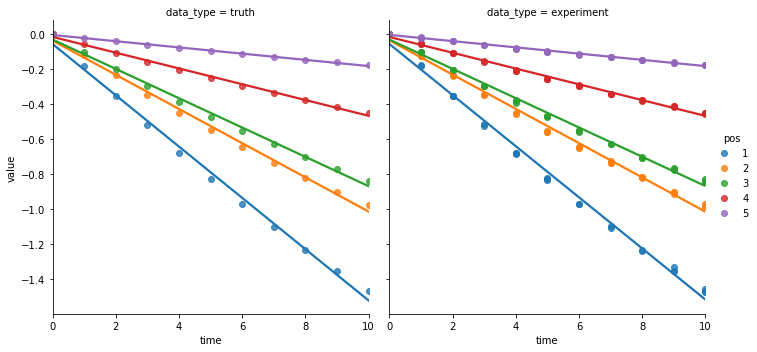

In [36]:
fg = sns.lmplot(data=df_melt[(df_melt[str_species].str.contains(str_species_mono_sum)) &
                             (df_melt[str_time] <= 10) &
                             (df_melt[str_val_type] == str_val_diff_log)],
                x=str_time, y=str_value, hue=str_pos, fit_reg=True, col=str_data_type, ci=None)

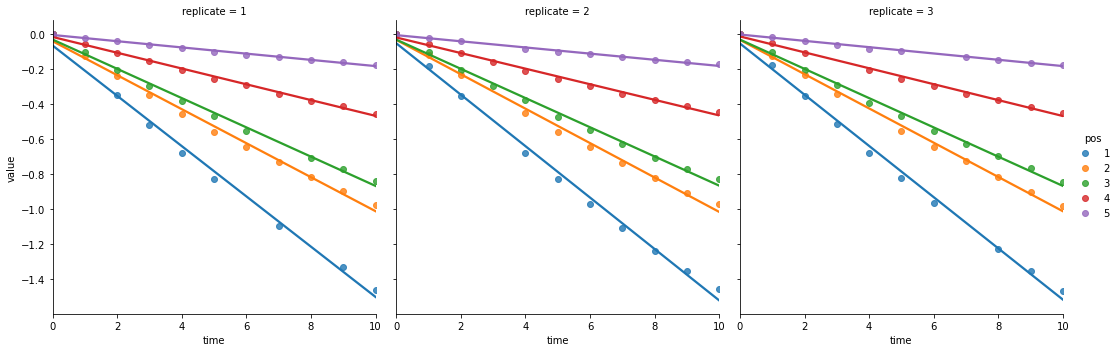

In [37]:
fg = sns.lmplot(data=df_melt[(df_melt[str_species].str.contains(str_species_mono_sum)) &
                             (df_melt[str_time] <= 10) & (df_melt[str_val_type] == str_val_diff_log) &
                             (df_melt[str_data_type] == str_type_exp)], 
                x=str_time, y=str_value, hue=str_pos, fit_reg=True, col=str_rep, ci=None)

In [38]:
kin_vars = get_kin_constants(rr)
df_keff = get_keff_df(kin_vars)

In [39]:
kin_vars

{'klys_1': 0.3,
 'klys_2': 0.1,
 'klys_3': 0.075,
 'klys_4': 0.03,
 'klys_5': 0.01,
 'kon': 0.001,
 'koff': 0.1,
 'kh': 0.05}

In [40]:
df_keff

,variable,k_2nd_true,pos
0,klys_1,0.000750,1
1,klys_2,0.000500,2
2,klys_3,0.000429,3
3,klys_4,0.000231,4
4,klys_5,0.000091,5


In [41]:
df_lin_fit = do_linear_fit(df_melt, variable=str_species_mono_sum, value_type=str_val_diff_log, fit_to='mean', fit_intercept=True, fit_y_errors=True, time_limit=10)
df_fit_merge = get_keff_exp_truth_merge(df_keff, df_lin_fit)
df_fit_merge

,variable,m,b,m_err,b_err,pos,fit_type,fit_y_errors,fit_intercept,k_1st_pseudo_fit,k_2nd_fit,k_2nd_true,fit_rel_error
0,MonoSum_1,-0.154343,-0.040686,0.003554,0.012916,1,mean,True,True,0.154343,0.000617,0.000750,0.176835
1,MonoSum_2,-0.097120,-0.054178,0.002126,0.011825,2,mean,True,True,0.097120,0.000388,0.000500,0.223041
2,MonoSum_3,-0.084332,-0.035530,0.001430,0.004775,3,mean,True,True,0.084332,0.000337,0.000429,0.212898
3,MonoSum_4,-0.045017,-0.029418,0.001276,0.006573,4,mean,True,True,0.045017,0.000180,0.000231,0.219707
4,MonoSum_5,-0.016994,-0.012142,0.000284,0.002004,5,mean,True,True,0.016994,0.000068,0.000091,0.252243


In [42]:
df_lin_fit = do_linear_fit(df_melt, variable=str_species_mono_sum, value_type=str_val_diff_log, fit_to='mean', fit_intercept=False, fit_y_errors=True, time_limit=10)
df_fit_merge = get_keff_exp_truth_merge(df_keff, df_lin_fit)
df_fit_merge

,variable,m,b,m_err,b_err,pos,fit_type,fit_y_errors,fit_intercept,k_1st_pseudo_fit,k_2nd_fit,k_2nd_true,fit_rel_error
0,MonoSum_1,-0.163522,0,0.002800,0,1,mean,True,False,0.163522,0.000654,0.000750,0.127884
1,MonoSum_2,-0.106041,0,0.001478,0,2,mean,True,False,0.106041,0.000424,0.000500,0.151669
2,MonoSum_3,-0.093034,0,0.002090,0,3,mean,True,False,0.093034,0.000372,0.000429,0.131685
3,MonoSum_4,-0.050587,0,0.000480,0,4,mean,True,False,0.050587,0.000202,0.000231,0.123159
4,MonoSum_5,-0.018599,0,0.000221,0,5,mean,True,False,0.018599,0.000074,0.000091,0.181665


In [43]:
df_lin_fit = do_linear_fit(df_melt, variable=str_species_mono_sum, value_type=str_val_diff_log, fit_to='mean', fit_intercept=False, fit_y_errors=True, time_limit=10)
df_fit_merge = get_keff_exp_truth_merge(df_keff, df_lin_fit)
df_fit_merge

,variable,m,b,m_err,b_err,pos,fit_type,fit_y_errors,fit_intercept,k_1st_pseudo_fit,k_2nd_fit,k_2nd_true,fit_rel_error
0,MonoSum_1,-0.163522,0,0.002800,0,1,mean,True,False,0.163522,0.000654,0.000750,0.127884
1,MonoSum_2,-0.106041,0,0.001478,0,2,mean,True,False,0.106041,0.000424,0.000500,0.151669
2,MonoSum_3,-0.093034,0,0.002090,0,3,mean,True,False,0.093034,0.000372,0.000429,0.131685
3,MonoSum_4,-0.050587,0,0.000480,0,4,mean,True,False,0.050587,0.000202,0.000231,0.123159
4,MonoSum_5,-0.018599,0,0.000221,0,5,mean,True,False,0.018599,0.000074,0.000091,0.181665


In [44]:
df_lin_fit = do_linear_fit(df_melt, variable=str_species_mono_sum, value_type=str_val_diff_log, fit_to='mean', fit_intercept=False, fit_y_errors=False, time_limit=10)
df_fit_merge = get_keff_exp_truth_merge(df_keff, df_lin_fit)
df_fit_merge

,variable,m,b,m_err,b_err,pos,fit_type,fit_y_errors,fit_intercept,k_1st_pseudo_fit,k_2nd_fit,k_2nd_true,fit_rel_error
0,MonoSum_1,-0.154439,0,0.002489,0,1,mean,False,False,0.154439,0.000618,0.000750,0.176324
1,MonoSum_2,-0.103160,0,0.001664,0,2,mean,False,False,0.103160,0.000413,0.000500,0.174723
2,MonoSum_3,-0.088295,0,0.001389,0,3,mean,False,False,0.088295,0.000353,0.000429,0.175911
3,MonoSum_4,-0.047613,0,0.000775,0,4,mean,False,False,0.047613,0.000190,0.000231,0.174700
4,MonoSum_5,-0.018749,0,0.000320,0,5,mean,False,False,0.018749,0.000075,0.000091,0.175053


In [45]:
df_lin_fit = do_linear_fit(df_melt, variable=str_species_mono_sum, value_type=str_val_diff_log, fit_to='truth', fit_intercept=False, fit_y_errors=True, time_limit=10)
df_fit_merge = get_keff_exp_truth_merge(df_keff, df_lin_fit)
df_fit_merge

,variable,m,b,m_err,b_err,pos,fit_type,fit_y_errors,fit_intercept,k_1st_pseudo_fit,k_2nd_fit,k_2nd_true,fit_rel_error
0,MonoSum_1,-0.154454,0,0.002429,0,1,truth,False,False,0.154454,0.000618,0.000750,0.176244
1,MonoSum_2,-0.102970,0,0.001619,0,2,truth,False,False,0.102970,0.000412,0.000500,0.176242
2,MonoSum_3,-0.088260,0,0.001388,0,3,truth,False,False,0.088260,0.000353,0.000429,0.176242
3,MonoSum_4,-0.047525,0,0.000747,0,4,truth,False,False,0.047525,0.000190,0.000231,0.176241
4,MonoSum_5,-0.018722,0,0.000294,0,5,truth,False,False,0.018722,0.000075,0.000091,0.176241


In [46]:
df_lin_fit = do_linear_fit(df_melt, variable=str_species_mono_sum, value_type=str_val_diff_log, fit_to=1, fit_intercept=False, fit_y_errors=True)
df_fit_merge = get_keff_exp_truth_merge(df_keff, df_lin_fit)
df_fit_merge

,variable,m,b,m_err,b_err,pos,fit_type,fit_y_errors,fit_intercept,k_1st_pseudo_fit,k_2nd_fit,k_2nd_true,fit_rel_error
0,MonoSum_1,-0.152922,0,0.003354,0,1,replicate_1,False,False,0.152922,0.000612,0.000750,0.184417
1,MonoSum_2,-0.103067,0,0.001757,0,2,replicate_1,False,False,0.103067,0.000412,0.000500,0.175461
2,MonoSum_3,-0.088252,0,0.001554,0,3,replicate_1,False,False,0.088252,0.000353,0.000429,0.176312
3,MonoSum_4,-0.047644,0,0.000740,0,4,replicate_1,False,False,0.047644,0.000191,0.000231,0.174167
4,MonoSum_5,-0.018763,0,0.000317,0,5,replicate_1,False,False,0.018763,0.000075,0.000091,0.174420


In [47]:
import warnings
warnings.filterwarnings('ignore')

In [48]:
def run_and_fit(sim_time=60, no_of_points=61, no_of_replicates=3, linker_conc=100, kh=2.5e-2, fit_to='truth', fit_intercept=False, fit_y_errors=True, fit_time_limit=10, noise_sparseness=0.15, noise_gaussian=0.06, de_mode=False):
    
    local_params = locals()
    def _get_fit(df_res, no_of_replicates, noise_params):
        df_melt = create_melt_df(df_res)
        df_melt = add_replicates(df_melt, no_replicates=no_of_replicates, noise_params=noise_params)
        df_melt = set_known_concentration_limits(df_melt, initial_lysine_conc=1)
        df_melt = calc_mono_sum_melt(df_melt)
        df_melt = create_diff_cols(df_melt, val_col=str_value)

        kin_vars = get_kin_constants(rr)
        df_keff = get_keff_df(kin_vars)
        df_lin_fit = do_linear_fit(df_melt, variable=str_species_mono_sum, value_type=str_val_diff_log, fit_to=fit_to, fit_intercept=fit_intercept, fit_y_errors=fit_y_errors, time_limit=fit_time_limit)
        df_fit_merge = get_keff_exp_truth_merge(df_keff, df_lin_fit)
        return df_fit_merge
    def _get_mean_error(df_fit_merge):
        mean_rel_error = df_fit_merge[str_fit_rel_error].mean()
        std_rel_error = df_fit_merge[str_fit_rel_error].std()
        params[str_mean_rel_error] = [mean_rel_error]
        params[str_std_rel_error] = [std_rel_error]
        df_res = pd.DataFrame.from_dict(params)
        return df_res
    def _get_mean_of_mean_error(df_error):
        mean_rel_error = df_error[str_mean_rel_error].mean()
        std_rel_error = df_error[str_std_rel_error].mean()
        params[str_mean_rel_error] = [mean_rel_error]
        params[str_std_rel_error] = [std_rel_error]
        df_res = pd.DataFrame.from_dict(params)
        return df_res

    
    noise_params = {"sparseness": noise_sparseness, "gaussian_noise": noise_gaussian}    
    params = {}
    n_times = 10

    
    
    for key in local_params:
        params[key] = [local_params[key]]

    
    
    rr = te.loadSBMLModel("/home/kai/Nextcloud-unikn/Coding/xlink_kme_sbml/output/model_example_mono_only_simple_25lys.xml")
    if str_species_crosslinker in sbml_sim_helper.get_rr_const_dict(rr, ''):
        linker = str_species_crosslinker
    else:
        linker = str_species_monolinker
    custom_vars = {'kh': kh, 'kon': 1e-4, 'koff': 1e-1, linker : linker_conc} #0.16768329
    rr.resetToOrigin()
    for k,v in custom_vars.items():
        setattr(rr, k, v)
    results = rr.simulate(0, sim_time, points=no_of_points)
    df_res = pd.DataFrame(results, columns=results.colnames)
    if fit_to == str_type_truth:
        df_fit = _get_fit(df_res, no_of_replicates=no_of_replicates, noise_params=noise_params)
        df_error = _get_mean_error(df_fit)
    else:
        df_list = []
        df_list2 = []
        for n in range(1, n_times + 1):
            df_fit = _get_fit(df_res, no_of_replicates=no_of_replicates, noise_params=noise_params)
            df_error = _get_mean_error(df_fit)
            df_list.append(df_error)
        df_fit_concat = pd.concat(df_list).reset_index(drop=True)
        df_error = _get_mean_of_mean_error(df_fit_concat)
    if de_mode:
        return df_error[str_mean_rel_error].iloc[0]
    return df_error

In [49]:
def run_and_fit_de_wrapper(parameters, *static_params):
    linker_conc,kh,fit_time_limit = parameters
    fit_to,fit_intercept,fit_y_errors,no_of_replicates = static_params
    res = run_and_fit(sim_time=60, no_of_points=61, no_of_replicates=no_of_replicates, linker_conc=linker_conc, kh=kh, fit_to=fit_to, fit_intercept=fit_intercept, fit_y_errors=fit_y_errors, fit_time_limit=fit_time_limit, de_mode=True)
    return res
    

In [50]:
res = run_and_fit(fit_to='mean', linker_conc=250, kh=2.5e-2, fit_time_limit=15, no_of_points=6, sim_time=15, no_of_replicates=10, noise_sparseness=0.15, noise_gaussian=0.05, fit_y_errors=False)
res

TypeError: run_and_fit() got an unexpected keyword argument 'noise_params'

In [1081]:
rest = run_and_fit(fit_to='truth', linker_conc=250, kh=2.5e-2, fit_time_limit=15, no_of_points=6, sim_time=15)
rest

,sim_time,no_of_points,linker_conc,kh,de_mode,fit_intercept,fit_time_limit,fit_to,fit_y_errors,no_of_replicates,mean_rel_error,std_rel_error
0,15,6,250,0.025,False,False,15,truth,True,3,0.017724,0.000003


In [1059]:
rest = run_and_fit(fit_to='truth', linker_conc=326, kh=7.95e-2, fit_time_limit=15)
rest

,sim_time,no_of_points,linker_conc,kh,de_mode,fit_intercept,fit_time_limit,fit_to,fit_y_errors,no_of_replicates,mean_rel_error,std_rel_error
0,60,61,326,0.0795,False,False,15,truth,True,3,0.002502,0.000002


In [1781]:
s_cxl = 250
s_kh = 5e-2
s_num_reps = 3
s_noise_gaussian = 0.06
s_noise_sparseness = 0.15
l_cxl = [100, 150, 200, 250, 300, 350]
l_n_reps = [2,3,5,10,20]
l_sparseness = [0, 0.05, 0.1, 0.15, 0.30, 0.50, 0.75]
l_noise = [0, 0.01, 0.03, 0.06, 0.12, 0.18, 0.25]

In [1750]:
list_cxl_truth = []
for cxl in l_cxl:
    list_cxl_truth.append(run_and_fit(fit_to='truth', linker_conc=cxl, kh=s_kh))
df_res_cxl_truth = pd.concat(list_cxl_truth).reset_index(drop=True)

In [1751]:
df_res_cxl_truth

,sim_time,no_of_points,no_of_replicates,linker_conc,kh,noise_sparseness,noise_gaussian,de_mode,fit_intercept,fit_time_limit,fit_to,fit_y_errors,mean_rel_error,std_rel_error
0,60,61,3,100,0.05,0.15,0.06,False,False,10,truth,True,0.587481,2.590972e-08
1,60,61,3,150,0.05,0.15,0.06,False,False,10,truth,True,0.381208,8.343420e-08
2,60,61,3,200,0.05,0.15,0.06,False,False,10,truth,True,0.174925,2.085288e-07
3,60,61,3,250,0.05,0.15,0.06,False,False,10,truth,True,0.031370,1.171515e-06
4,60,61,3,300,0.05,0.15,0.06,False,False,10,truth,True,0.237672,1.478531e-06
5,60,61,3,350,0.05,0.15,0.06,False,False,10,truth,True,0.443981,5.111024e-07


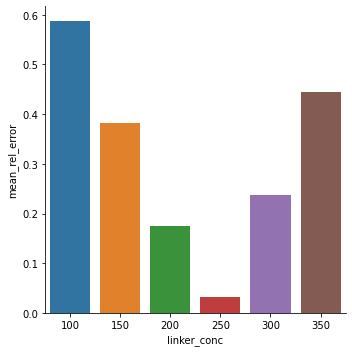

In [1762]:
sns.catplot(data=df_res_cxl_truth, y=str_mean_rel_error, x=str_conc_linker, kind='bar')

In [1782]:
list_n_reps_mean = []
list_n_reps_mean.append(run_and_fit(fit_to='truth', linker_conc=s_cxl, kh=s_kh, no_of_replicates=0))
for n_rep in l_n_reps:
    list_n_reps_mean.append(run_and_fit(fit_to='mean', linker_conc=s_cxl, kh=s_kh, no_of_replicates=n_rep))
df_res_n_reps_mean = pd.concat(list_n_reps_mean).reset_index(drop=True)

In [1783]:
df_res_n_reps_mean

,sim_time,no_of_points,no_of_replicates,linker_conc,kh,noise_sparseness,noise_gaussian,de_mode,fit_intercept,fit_time_limit,fit_to,fit_y_errors,mean_rel_error,std_rel_error
0,60,61,0,250,0.05,0.15,0.06,False,False,10,truth,True,0.031370,0.000001
1,60,61,2,250,0.05,0.15,0.06,False,False,10,mean,True,0.315508,0.389552
2,60,61,3,250,0.05,0.15,0.06,False,False,10,mean,True,0.253527,0.271909
3,60,61,5,250,0.05,0.15,0.06,False,False,10,mean,True,0.149348,0.168455
4,60,61,10,250,0.05,0.15,0.06,False,False,10,mean,True,0.104165,0.115340
5,60,61,20,250,0.05,0.15,0.06,False,False,10,mean,True,0.090702,0.098328


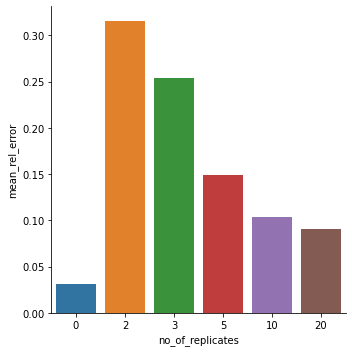

In [1784]:
sns.catplot(data=df_res_n_reps_mean, y=str_mean_rel_error, x='no_of_replicates', kind='bar')

In [1756]:
list_noise_mean = []
#list_noise_mean.append(run_and_fit(fit_to='truth', linker_conc=s_cxl, kh=s_kh, no_of_replicates=0))
for sparse in l_sparseness:
    for noise in l_noise:
        list_noise_mean.append(run_and_fit(fit_to='mean', linker_conc=s_cxl, kh=s_kh, no_of_replicates=n_rep, noise_sparseness=sparse, noise_gaussian=noise))
df_res_noise_mean = pd.concat(list_noise_mean).reset_index(drop=True)
df_res_noise_mean["noise_sparseness"] = pd.Categorical(df_res_noise_mean["noise_sparseness"])

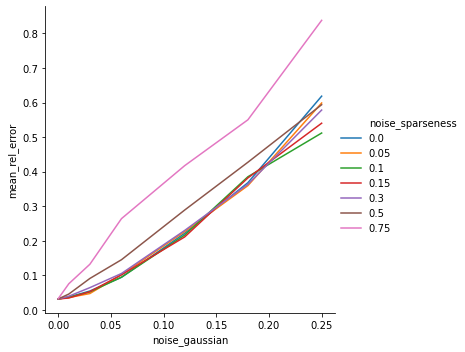

In [1789]:
fg = sns.relplot(data=df_res_noise_mean, y=str_mean_rel_error, x='noise_gaussian', kind='line', hue="noise_sparseness")

In [1031]:
#linker_conc,kh,fit_time_limit
bounds = [(25, 350), (1e-6, 1e-1), (5, 20)]
# fit_to,fit_intercept,fit_y_errors,no_of_replicates
args = ("truth", False, True, 3)

In [1051]:
de = scipy.optimize.differential_evolution(run_and_fit_de_wrapper, bounds, args=args, maxiter=None, workers=-1)

In [1030]:
de

     fun: 9.358649409953872e-07
 message: 'Optimization terminated successfully.'
    nfev: 1542
     nit: 33
 success: True
       x: array([2.40000000e+02, 2.42803481e-02, 1.00000000e+01])

In [1052]:
de

     fun: 1.3870150720094955e-06
 message: 'Optimization terminated successfully.'
    nfev: 3664
     nit: 79
 success: True
       x: array([3.26872417e+02, 7.95728105e-02, 1.51828864e+01])